In [306]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.datasets import make_classification, make_moons, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import time



In [307]:
def gini_impurity(y):
    m = len(y)
    if m == 0:
        return 0
    return 1.0 - sum((np.sum(y == c) / m) ** 2 for c in np.unique(y))

In [308]:
def best_split(X, y, features):
    best_gini = 1.0
    best_idx, best_thr = None, None
    
    for idx in features:
        thresholds = np.unique(X[:, idx])
        for thr in thresholds:
            y_left = y[X[:, idx] <= thr]
            y_right = y[X[:, idx] > thr]
            if len(y_left) == 0 or len(y_right) == 0:
                continue
            gini_left = gini_impurity(y_left)
            gini_right = gini_impurity(y_right)
            gini = (len(y_left) / len(y)) * gini_left + (len(y_right) / len(y)) * gini_right
            
            if gini < best_gini:
                best_gini = gini
                best_idx = idx
                best_thr = thr
    
    return best_idx, best_thr

In [309]:
class DecisionTree:
    def __init__(self, max_features):
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)
    
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        if n_labels == 1:
            return y[0]
        
        feature_idxs = np.random.choice(n_features, self.max_features, replace=False)
        best_idx, best_thr = best_split(X, y, feature_idxs)
        
        if best_idx is None:
            return np.bincount(y).argmax()
        
        indices_left = X[:, best_idx] <= best_thr
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]
        
        return {
            'feature_idx': best_idx,
            'threshold': best_thr,
            'left': self._grow_tree(X_left, y_left, depth + 1),
            'right': self._grow_tree(X_right, y_right, depth + 1)
        }
    
    def predict(self, X):
        return np.array([self._predict(inputs) for inputs in X])
    
    def _predict(self, inputs):
        node = self.tree
        while isinstance(node, dict):
            if inputs[node['feature_idx']] <= node['threshold']:
                node = node['left']
            else:
                node = node['right']
        return node

In [310]:
class RandomForest:
    def __init__(self, n_trees, max_features):
        self.n_trees = n_trees
        self.max_features = max_features
        self.trees = []
    
    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        
        for _ in range(self.n_trees):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            tree = DecisionTree(max_features=self.max_features)
            tree.fit(X[idxs], y[idxs])
            self.trees.append(tree)
    
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        return np.array([np.bincount(tree_pred).argmax() for tree_pred in tree_preds])

In [311]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

In [312]:
n_samples = 2593
random_state = 254493

In [313]:
X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.1, random_state=random_state)
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, test_size=0.2, random_state=random_state)

X_clf, y_clf = make_classification(random_state=random_state, n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=random_state)

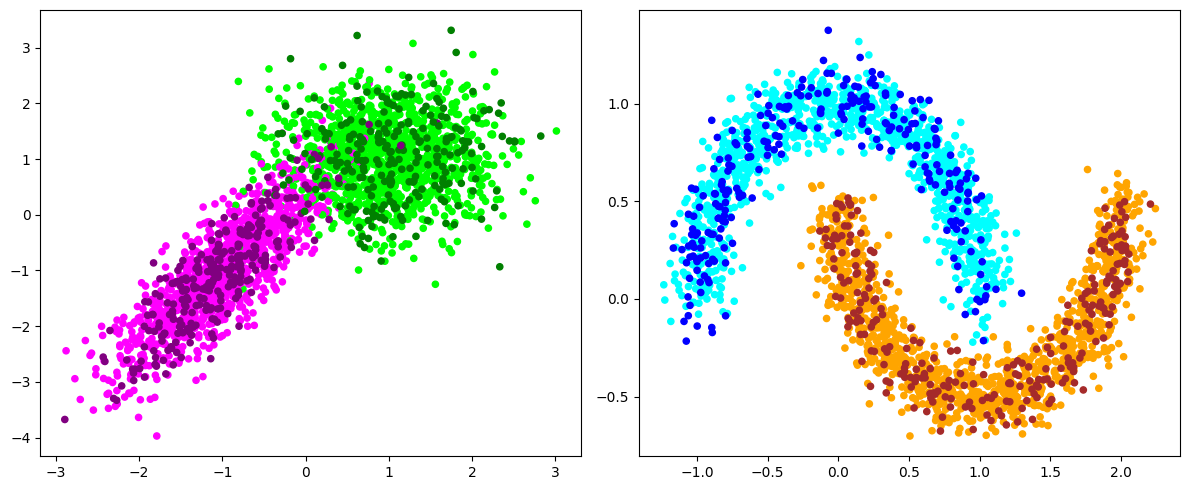

In [314]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_clf[:, 0], X_train_clf[:, 1], c=np.where(y_train_clf==0, 'lime', 'magenta'), s=20)
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1], c=np.where(y_test_clf==0, 'green', 'purple'), s=20)


plt.subplot(1, 2, 2)
plt.scatter(X_train_moons[:, 0], X_train_moons[:, 1], c=np.where(y_train_moons==0, 'cyan', 'orange'), s=20)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=np.where(y_test_moons==0, 'blue', 'brown'), s=20)

plt.tight_layout()
plt.show()

In [315]:
forest = RandomForest(n_trees=10, max_features=1)
forest.fit(X_train_moons, y_train_moons)
y_pred = forest.predict(X_test_moons)

acc = accuracy(y_test_moons, y_pred)
print(f'Accuracy: {acc:.2f}')

Accuracy: 1.00


In [316]:
sklearn_forest = RandomForestClassifier(n_estimators=100, max_features=1, random_state=random_state)
sklearn_forest.fit(X_train_moons, y_train_moons)
sklearn_y_pred = sklearn_forest.predict(X_test_moons)

sklearn_acc = accuracy_score(y_test_moons, sklearn_y_pred)
print(f'scikit-learn Accuracy: {sklearn_acc:.2f}')


scikit-learn Accuracy: 1.00


In [317]:
def plot_decision_boundaries(X, y, model1, model2, c1, c2, title1="Custom Random Forest implementation result", title2="scikit-learn result"):
    x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z1 = model1.predict(np.c_[xx.ravel(), yy.ravel()])
    Z1 = Z1.reshape(xx.shape)
    
    Z2 = model2.predict(np.c_[xx.ravel(), yy.ravel()])
    Z2 = Z2.reshape(xx.shape)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.contourf(xx, yy, Z1, alpha=0.2, levels=np.linspace(Z1.min(), Z1.max(), 3), colors=[c1, c2])
    ax1.contour(xx, yy, Z1, levels=[0.5], colors="black", vmin=0, vmax=1)
    colors1 = np.where(y == 0, c1, c2)
    ax1.scatter(X[:, 0], X[:, 1], c=colors1, s=5)
    ax1.set_title(f'{title1} Decision Boundary')
    
    ax2.contourf(xx, yy, Z2, alpha=0.2, levels=np.linspace(Z2.min(), Z2.max(), 3), colors=[c1, c2])
    ax2.contour(xx, yy, Z2, levels=[0.5], colors="black", vmin=0, vmax=1)
    colors2 = np.where(y == 0, c1, c2)
    ax2.scatter(X[:, 0], X[:, 1], c=colors2, s=5)
    ax2.set_title(f'{title2} Decision Boundary')
    
    plt.show()

In [318]:
def calculate_sensitivity_specificity(cm):
    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return sensitivity, specificity


In [319]:
def plot_confusion_matrix_and_roc(X_test, y_test, model1, model2, model1_name="Custom Model", model2_name="scikit-learn Model"):
    y_pred1 = model1.predict(X_test)
    y_pred2 = model2.predict(X_test)
    
    cm1 = confusion_matrix(y_test, y_pred1)
    cm2 = confusion_matrix(y_test, y_pred2)
    
    fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
    roc_auc1 = auc(fpr1, tpr1)
    roc_auc2 = auc(fpr2, tpr2)
    
    sensitivity1, specificity1 = calculate_sensitivity_specificity(cm1)
    sensitivity2, specificity2 = calculate_sensitivity_specificity(cm2)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
    axes[0, 0].set_title(f'{model1_name} Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    axes[0, 0].text(1.5, -0.5, f'Sensitivity: {sensitivity1:.2f}', va='center', ha='center', backgroundcolor='lightblue', alpha=0.5, fontsize=12, bbox=dict(facecolor='white', edgecolor='blue'))
    axes[0, 0].text(1.5, -0.25, f'Specificity: {specificity1:.2f}', va='center', ha='center', backgroundcolor='lightblue', alpha=0.5, fontsize=12, bbox=dict(facecolor='white', edgecolor='blue'))
    

    sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
    axes[0, 1].set_title(f'{model2_name} Confusion Matrix')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')

    axes[0, 1].text(1.5, -0.5, f'Sensitivity: {sensitivity2:.2f}', va='center', ha='center', backgroundcolor='lightblue', alpha=0.5, fontsize=12, bbox=dict(facecolor='white', edgecolor='blue'))
    axes[0, 1].text(1.5, -0.25, f'Specificity: {specificity2:.2f}', va='center', ha='center', backgroundcolor='lightblue', alpha=0.5, fontsize=12, bbox=dict(facecolor='white', edgecolor='blue'))
    
    axes[1, 0].plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC curve (area = {roc_auc1:.2f})')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('False Positive Rate')
    axes[1, 0].set_ylabel('True Positive Rate')
    axes[1, 0].set_title(f'{model1_name} ROC Curve')
    axes[1, 0].legend(loc="lower right")
    
    axes[1, 1].plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
    axes[1, 1].set_xlim([0.0, 1.0])
    axes[1, 1].set_ylim([0.0, 1.05])
    axes[1, 1].set_xlabel('False Positive Rate')
    axes[1, 1].set_ylabel('True Positive Rate')
    axes[1, 1].set_title(f'{model2_name} ROC Curve')
    axes[1, 1].legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

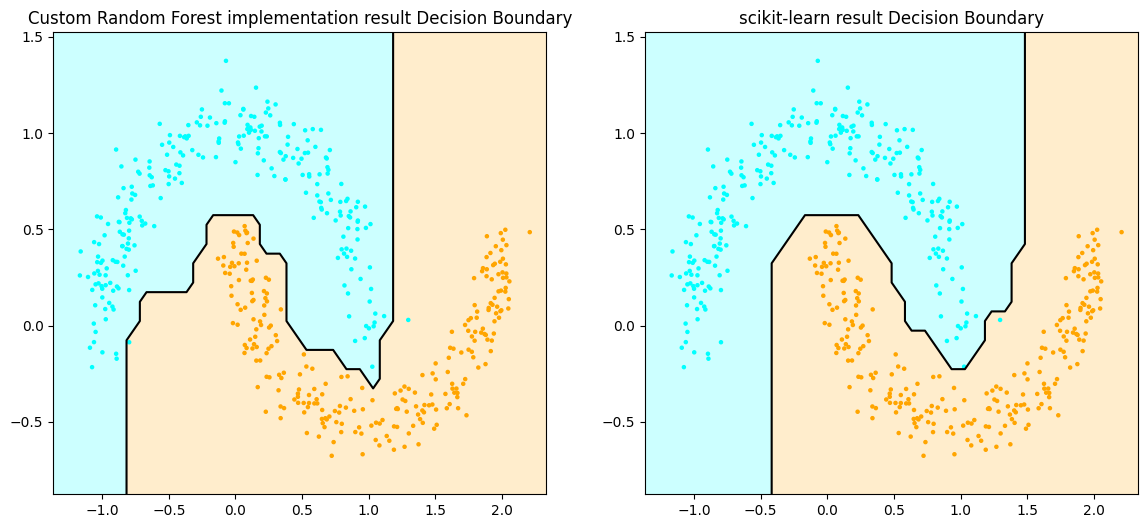

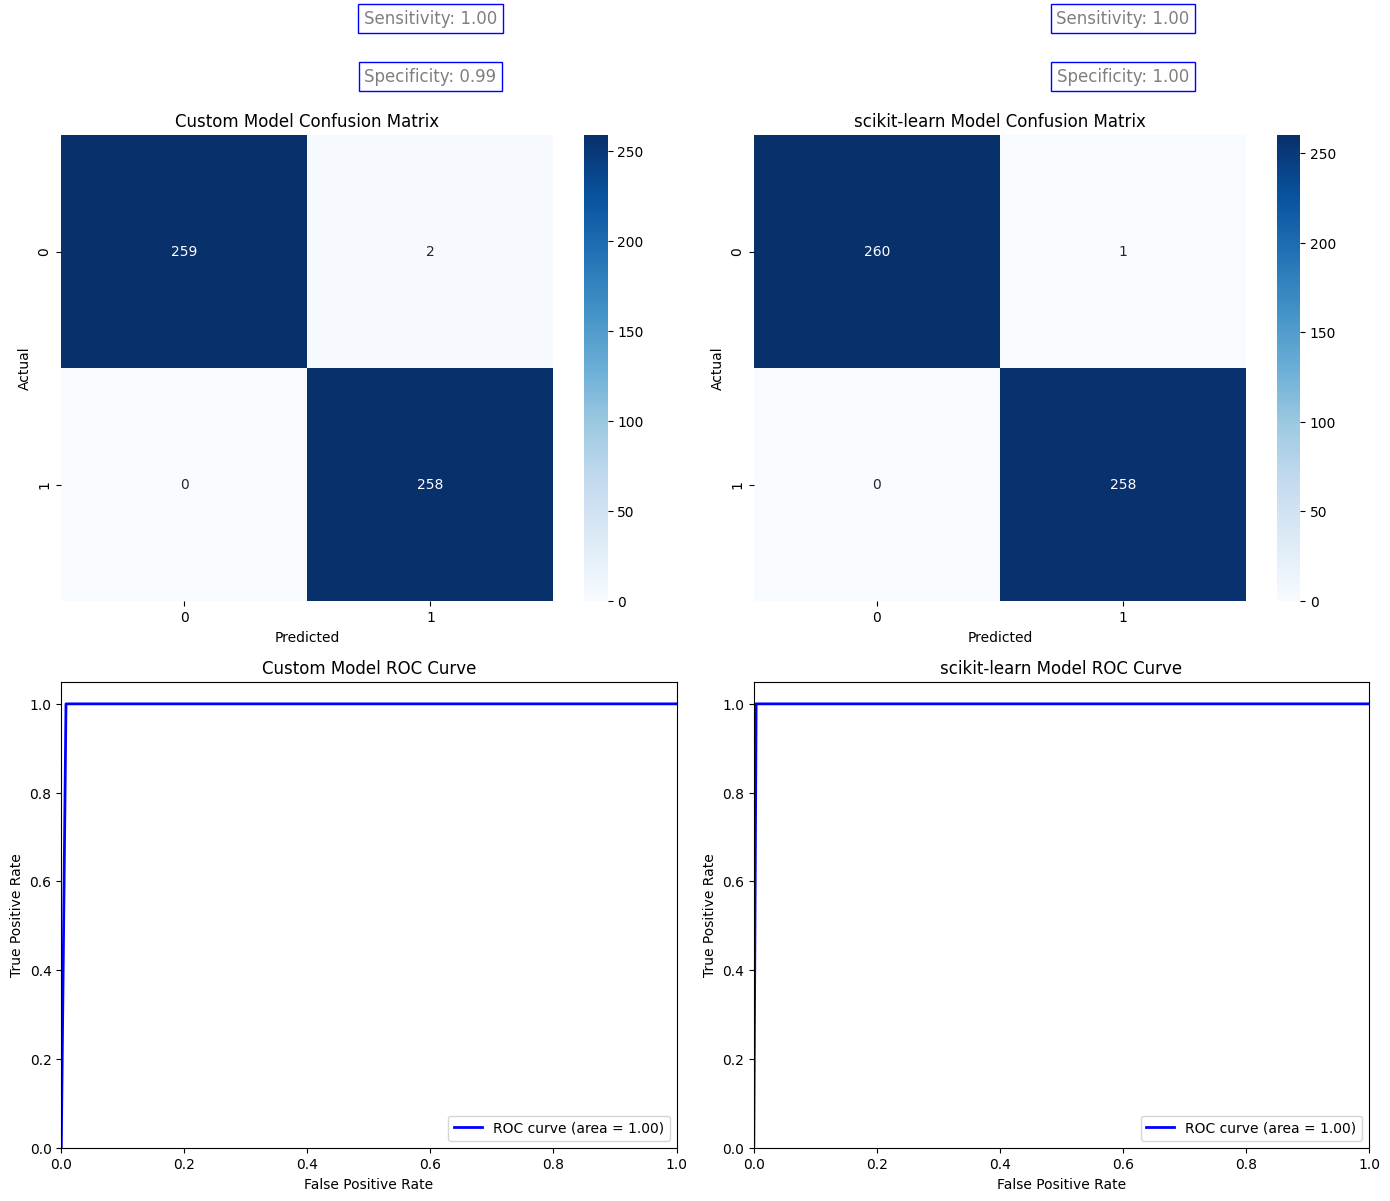

In [320]:
plot_decision_boundaries(X_test_moons, y_test_moons, forest, sklearn_forest, 'cyan', 'orange')
plot_confusion_matrix_and_roc(X_test_moons, y_test_moons, forest, sklearn_forest)

In [321]:
forest = RandomForest(n_trees=10, max_features=1)
forest.fit(X_train_clf, y_train_clf)
y_pred = forest.predict(X_test_clf)

acc = accuracy(y_test_clf, y_pred)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.96


In [322]:
sklearn_forest = RandomForestClassifier(n_estimators=100, max_features=1, random_state=random_state)
sklearn_forest.fit(X_train_clf, y_train_clf)
sklearn_y_pred = sklearn_forest.predict(X_test_clf)

# Obliczanie dokładności
sklearn_acc = accuracy_score(y_test_clf, sklearn_y_pred)
print(f'scikit-learn Accuracy: {sklearn_acc:.2f}')

scikit-learn Accuracy: 0.97


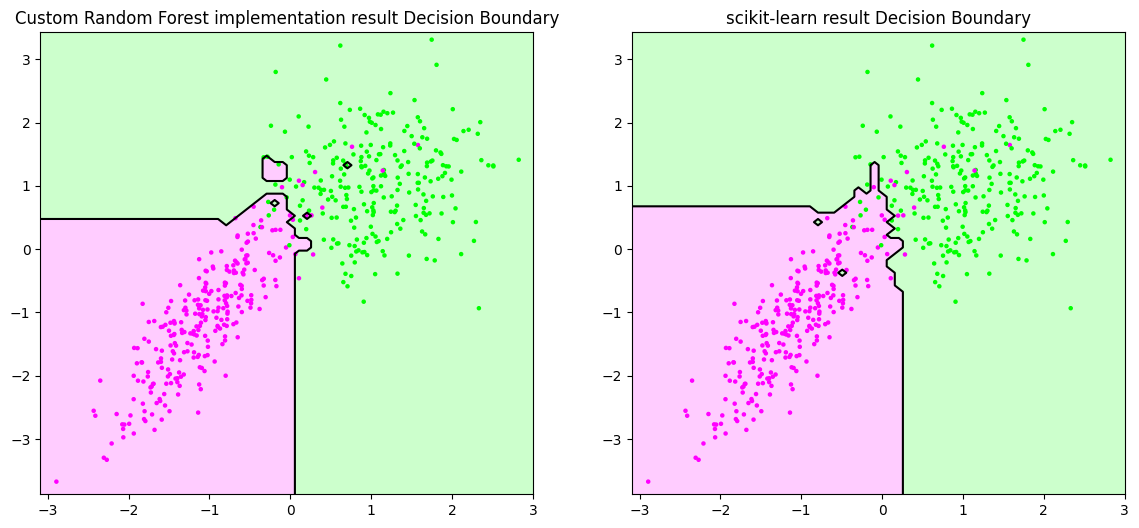

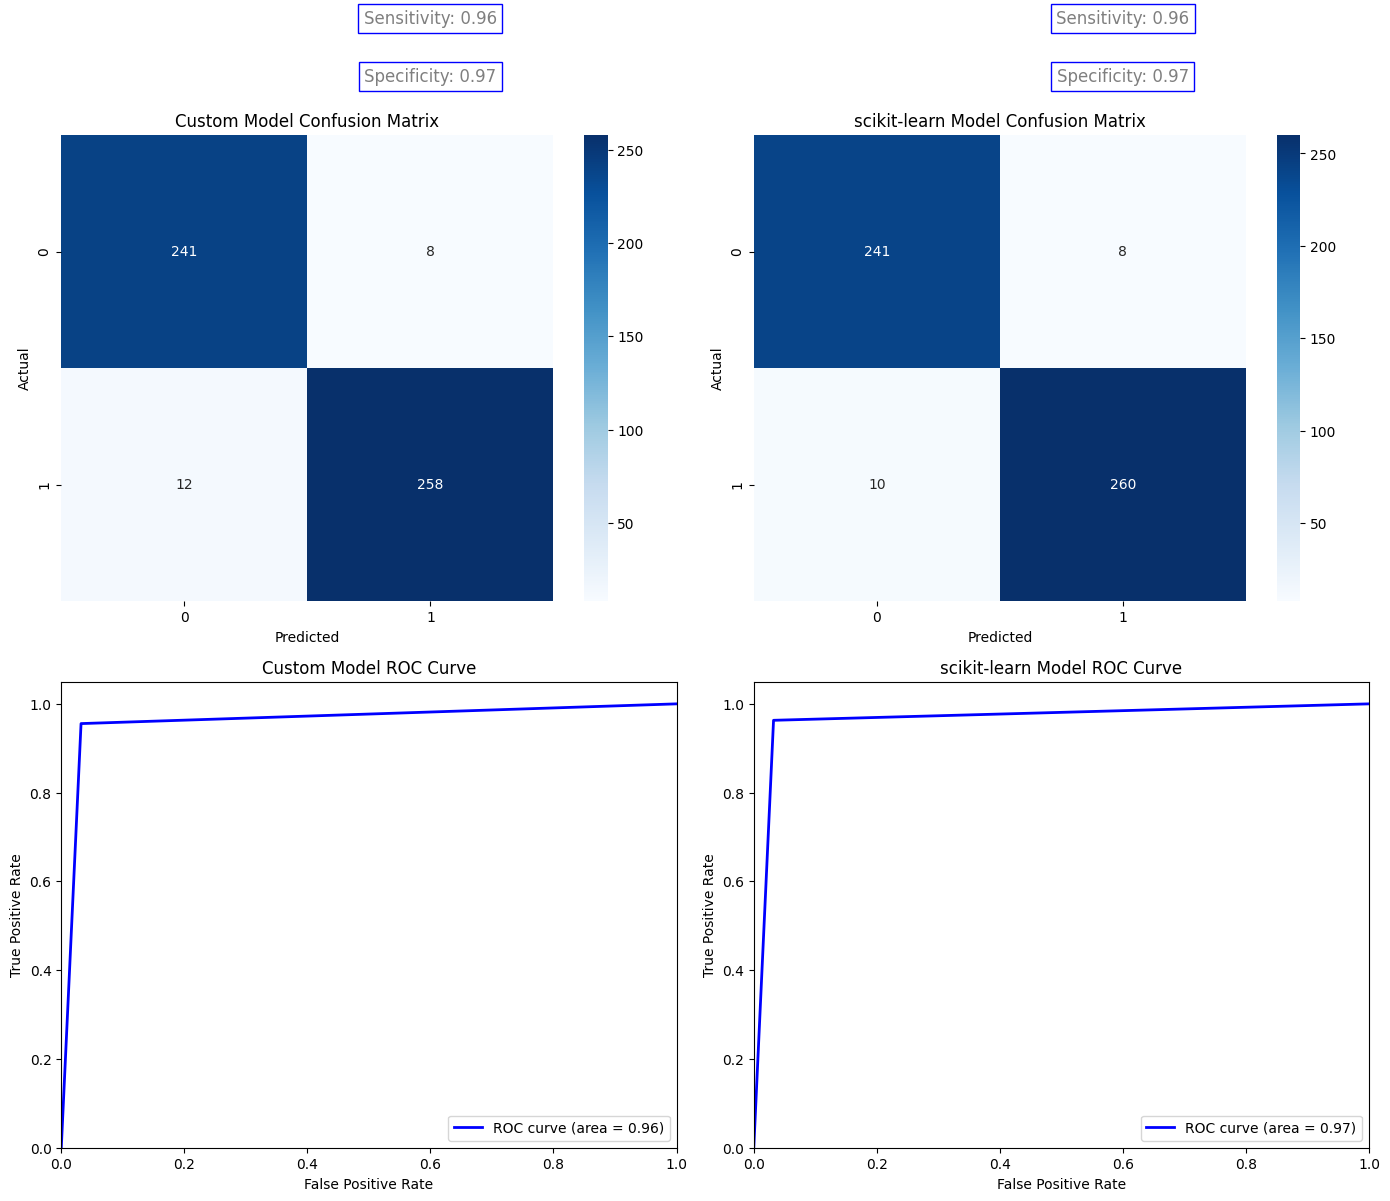

In [323]:
plot_decision_boundaries(X_test_clf, y_test_clf, forest, sklearn_forest, 'lime', 'magenta')
plot_confusion_matrix_and_roc(X_test_clf, y_test_clf, forest, sklearn_forest)

In [324]:
X_clf2, y_clf2 = make_classification(random_state=random_state, n_samples=2*n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=2)

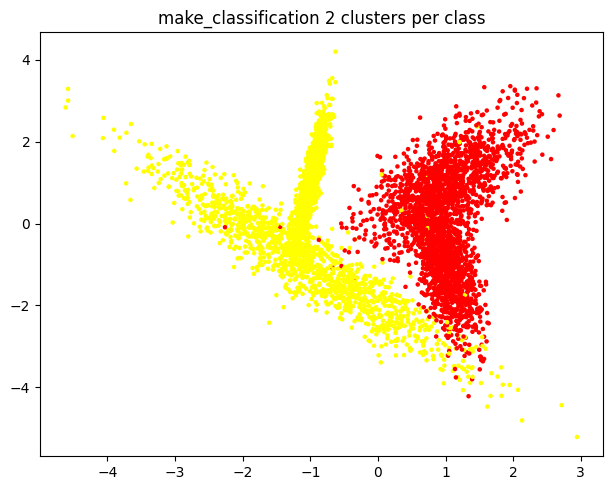

In [325]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_clf2[:, 0], X_clf2[:, 1], c=np.where(y_clf2==0, 'yellow', 'red'), s=5)
plt.title('make_classification 2 clusters per class')

plt.tight_layout()
plt.show()

In [326]:
X_train_clf2, X_test_clf2, y_train_clf2, y_test_clf2 = train_test_split(X_clf2, y_clf2, test_size=0.2, random_state=random_state)


In [327]:
forest = RandomForest(n_trees=10, max_features=1)
forest.fit(X_train_clf2, y_train_clf2)
y_pred = forest.predict(X_test_clf2)

acc = accuracy(y_test_clf2, y_pred)
print(f'Accuracy: {acc:.2f}')

Accuracy: 0.98


In [328]:
sklearn_forest = RandomForestClassifier(n_estimators=100, max_features=1, random_state=5)
sklearn_forest.fit(X_train_clf2, y_train_clf2)
sklearn_y_pred = sklearn_forest.predict(X_test_clf2)

# Obliczanie dokładności
sklearn_acc = accuracy_score(y_test_clf2, sklearn_y_pred)
print(f'scikit-learn Accuracy: {sklearn_acc:.2f}')

scikit-learn Accuracy: 0.98


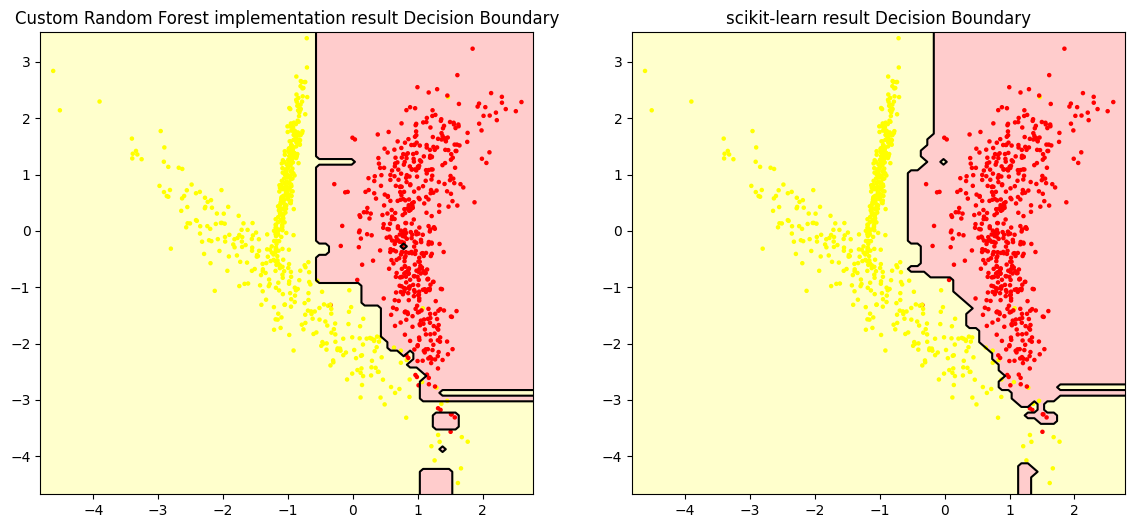

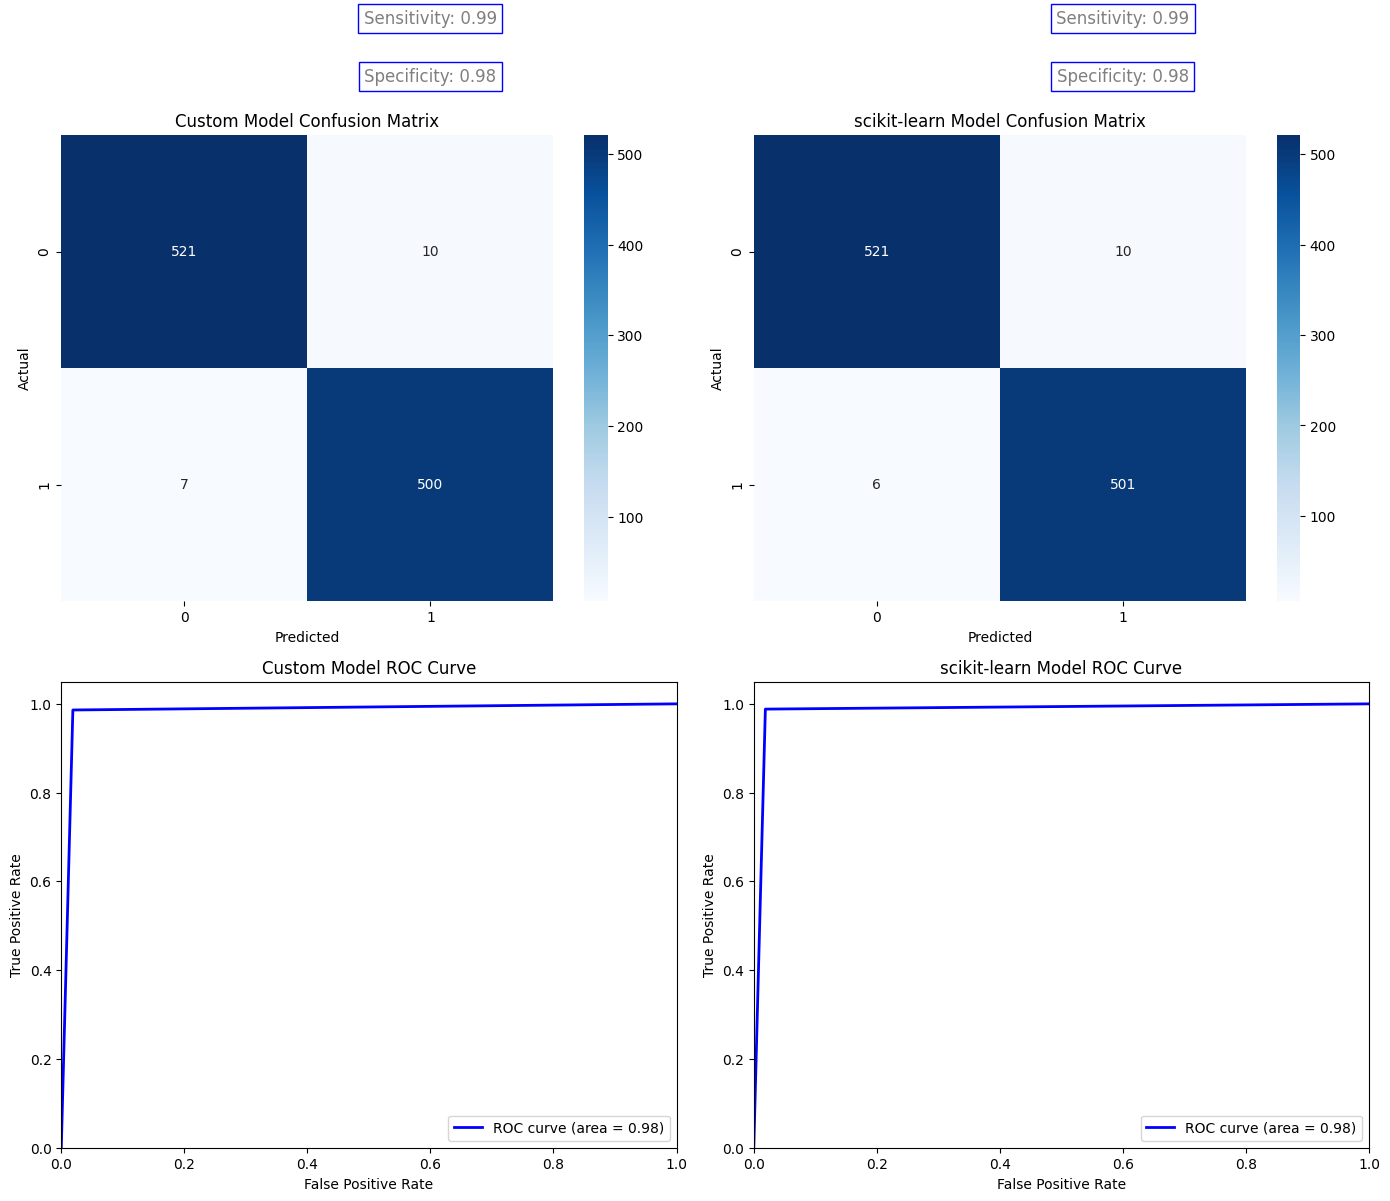

In [329]:
plot_decision_boundaries(X_test_clf2, y_test_clf2, forest, sklearn_forest, 'yellow', 'red')
plot_confusion_matrix_and_roc(X_test_clf2, y_test_clf2, forest, sklearn_forest)

# NASA

In [330]:
data = pd.read_csv('NASA_JPL_asteroid.csv')
data

C:\Users\peter\AppData\Local\Temp\ipykernel_21020\1837644283.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('NASA_JPL_asteroid.csv')


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.400,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.200,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.330,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.000,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.900,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958519,bPLS6013,3246801,(6013 P-L),6013 P-L,NaN,NaN,N,N,17.135,NaN,...,6.969000e+00,7.433000e+00,4.631100e+01,2.738300e+01,1.041200e+00,1.652100e-01,1.309700e+02,7.264900e+02,MBA,0.23839
958520,bPLS6331,3246834,(6331 P-L),6331 P-L,NaN,NaN,N,N,18.500,NaN,...,1.563500e-05,5.598600e-05,2.380400e-04,1.298200e-04,2.418900e-08,3.346100e-09,4.690200e-04,1.578500e-05,MBA,0.53633
958521,bPLS6344,3013075,(6344 P-L),6344 P-L,NaN,NaN,Y,Y,20.400,NaN,...,1.853300e-05,5.691700e-05,8.969200e-05,5.272600e-05,1.650100e-07,1.101600e-08,2.830600e-04,9.127500e-05,APO,0.51556
958522,bT2S2060,3246457,(2060 T-2),2060 T-2,NaN,NaN,N,N,18.071,NaN,...,5.448800e-01,4.391600e+00,1.898800e+01,1.083800e+01,7.171600e-01,1.016700e-01,3.898400e+01,5.035500e+02,MBA,0.25641


In [331]:
# for col in data.columns:
#     unique_values_count = data[col].nunique()
#     print(col, ' --> ', unique_values_count)

In [332]:
df = pd.DataFrame(data)
del df['id']
del df['spkid']
del df['full_name']
del df['pdes']
del df['name']
del df['prefix']
del df['orbit_id']
del df['equinox']

df.shape

(958524, 37)

Usuń kolumny mające więcej in 30% brakujących wartości

In [333]:
threshold = 0.7 * len(df)
df.dropna(thresh=threshold, axis=1, inplace=True)

In [334]:
df.shape

(958524, 34)

Dokonaj imputacji brakujących wartości zakładając że są one MCAR (Missing Completely At Random) - zmienne kategoryczne należy zastąpić dominantą a dane numeryczne medianą.

In [335]:
X_neo = df[[col for col in df.columns if col != 'neo']]
y_neo = df['neo']

Usuwam wiersze gdzie NEO jest NaNem

In [336]:
nan_indices = y_neo[y_neo.isna()].index

In [337]:
X_neo = X_neo.drop(nan_indices)
y_neo = y_neo.drop(nan_indices)

In [338]:
y_neo = y_neo.replace({'N': 0, 'Y': 1})

In [339]:
for col in X_neo.columns:
    if X_neo[col].dtype == 'object':
        X_neo[col].fillna(X_neo[col].mode()[0], inplace=True)
    else:
        X_neo[col].fillna(X_neo[col].median(), inplace=True)

In [340]:
numerical_cols = X_neo.select_dtypes(include=['float64', 'int64'])

Dokonaj winsoryzacji danych odstających ponad 1.5 IQR.

In [341]:
stats_df_before_winsorizing = pd.DataFrame()
for col in numerical_cols:
    stats_df_before_winsorizing[col] = X_neo[col].describe()
stats_df_before_winsorizing = stats_df_before_winsorizing.T
stats_df_before_winsorizing

,count,mean,std,min,25%,50%,75%,max
H,958520.0,1.690638e+01,1.784510e+00,-1.100000e+00,1.610000e+01,1.690000e+01,1.770000e+01,3.320000e+01
epoch,958520.0,2.458869e+06,7.016678e+02,2.425052e+06,2.459000e+06,2.459000e+06,2.459000e+06,2.459000e+06
epoch_mjd,958520.0,5.886879e+04,7.016678e+02,2.505100e+04,5.900000e+04,5.900000e+04,5.900000e+04,5.900000e+04
epoch_cal,958520.0,2.019693e+07,1.930344e+04,1.927062e+07,2.020053e+07,2.020053e+07,2.020053e+07,2.020053e+07
e,958520.0,1.561117e-01,9.261238e-02,0.000000e+00,9.219240e-02,1.450011e-01,2.006494e-01,9.998508e-01
a,958520.0,2.925348e+00,3.595804e+01,5.554178e-01,2.387837e+00,2.646970e+00,3.001933e+00,3.348890e+04
q,958520.0,2.394876e+00,2.139234e+00,7.051073e-02,1.971401e+00,2.225815e+00,2.578311e+00,8.039882e+01
i,958520.0,9.054564e+00,6.634826e+00,7.744220e-03,4.165402e+00,7.415645e+00,1.240750e+01,1.750829e+02
om,958520.0,1.684564e+02,1.028817e+02,2.451052e-05,8.060440e+01,1.598269e+02,2.522475e+02,3.599998e+02
w,958520.0,1.813693e+02,1.038879e+02,1.299944e-04,9.148206e+01,1.823579e+02,2.715213e+02,3.599996e+02


In [342]:
for col in numerical_cols:
    Q1 = X_neo[col].quantile(0.25)
    Q3 = X_neo[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_limit = (X_neo[col] < lower_bound).mean()
    upper_limit = (X_neo[col] > upper_bound).mean()

    
    X_neo[col] = winsorize(X_neo[col], limits=(lower_limit, upper_limit))

In [343]:
stats_df_after_winsorizing= pd.DataFrame()
for col in numerical_cols:
    stats_df_after_winsorizing[col] = X_neo[col].describe()

stats_df_after_winsorizing = stats_df_after_winsorizing.T
stats_df_after_winsorizing

,count,mean,std,min,25%,50%,75%,max
H,958520.0,1.687366e+01,1.357450e+00,1.370100e+01,1.610000e+01,1.690000e+01,1.770000e+01,2.009900e+01
epoch,958520.0,2.459000e+06,0.000000e+00,2.459000e+06,2.459000e+06,2.459000e+06,2.459000e+06,2.459000e+06
epoch_mjd,958520.0,5.900000e+04,0.000000e+00,5.900000e+04,5.900000e+04,5.900000e+04,5.900000e+04,5.900000e+04
epoch_cal,958520.0,2.020053e+07,0.000000e+00,2.020053e+07,2.020053e+07,2.020053e+07,2.020053e+07,2.020053e+07
e,958520.0,1.524873e-01,7.868601e-02,0.000000e+00,9.219240e-02,1.450011e-01,2.006494e-01,3.633210e-01
a,958520.0,2.674982e+00,3.926381e-01,1.466679e+00,2.387837e+00,2.646970e+00,3.001933e+00,3.923001e+00
q,958520.0,2.267088e+00,4.293160e-01,1.061048e+00,1.971401e+00,2.225815e+00,2.578311e+00,3.488635e+00
i,958520.0,8.908918e+00,6.048940e+00,7.744220e-03,4.165402e+00,7.415645e+00,1.240750e+01,2.477049e+01
om,958520.0,1.684564e+02,1.028817e+02,2.451052e-05,8.060440e+01,1.598269e+02,2.522475e+02,3.599998e+02
w,958520.0,1.813693e+02,1.038879e+02,1.299944e-04,9.148206e+01,1.823579e+02,2.715213e+02,3.599996e+02


In [344]:
# for col in X_test_neo.columns:
#     unique_values_count = X_test_neo[col].nunique()
#     print(col, ' --> ', unique_values_count)

In [345]:
del X_neo['epoch']
del X_neo['epoch_mjd']
del X_neo['epoch_cal']
numerical_cols = X_neo.select_dtypes(include=['float64', 'int64'])

In [346]:
X_train_neo, X_test_neo, y_train_neo, y_test_neo = train_test_split(X_neo, y_neo, test_size=0.9, stratify=y_neo)

Znormalizuj dane numeryczne
i zakoduj (one-hot) dane kategoryczne.

In [347]:
X_train_neo

,pha,H,e,a,q,i,om,w,ma,ad,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
527159,N,16.300,0.030941,3.130066,3.033219,16.756738,212.845807,154.766813,134.627553,3.226914,...,0.000011,0.000028,0.000167,0.000167,5.998300e-08,4.962500e-09,0.000934,0.000056,MBA,0.63563
348034,N,16.400,0.264662,3.036199,2.232633,5.004696,223.509947,127.400954,80.367965,3.839765,...,0.000009,0.000078,0.000083,0.000024,3.558900e-08,2.590000e-09,0.000127,0.000027,MBA,0.49483
874050,N,17.448,0.083721,3.021331,2.768384,11.087847,27.496345,72.790733,317.600160,3.274279,...,0.000030,0.000336,0.000655,0.000366,2.494400e-07,2.266900e-08,0.001753,0.000206,MBA,0.65780
9704,N,13.701,0.128739,3.046335,2.654154,10.698035,24.467395,15.633267,353.833517,3.438516,...,0.000005,0.000021,0.000028,0.000018,2.062200e-08,1.667600e-09,0.000096,0.000017,MBA,0.52001
951295,N,19.170,0.224438,2.191368,1.699542,8.168399,350.735744,351.437092,90.969833,2.683194,...,0.000030,0.000125,0.000655,0.000366,2.494400e-07,2.266900e-08,0.001753,0.000206,MBA,0.37421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736890,N,16.700,0.021592,3.119163,3.051816,9.510960,282.892304,164.809824,110.878323,3.186511,...,0.000010,0.000051,0.000262,0.000250,1.161700e-07,9.784100e-09,0.001407,0.000110,MBA,0.70710
767942,N,18.865,0.080307,2.531366,2.328079,7.967087,183.403263,269.724471,60.475604,2.734652,...,0.000030,0.000336,0.000655,0.000366,2.494400e-07,2.266900e-08,0.001753,0.000206,MBA,0.62850
432877,N,16.200,0.040804,2.969172,2.848018,12.803545,74.745164,169.973189,269.144776,3.090326,...,0.000008,0.000025,0.000078,0.000078,4.748400e-08,4.440100e-09,0.000410,0.000043,MBA,0.59385
561185,N,18.500,0.204450,2.194168,1.745569,5.459208,346.281888,10.519085,166.925760,2.642767,...,0.000008,0.000059,0.000063,0.000019,1.568800e-08,2.700200e-09,0.000061,0.000011,MBA,0.56768


In [348]:
scaler = StandardScaler()
X_train_neo[numerical_cols.columns] = scaler.fit_transform(X_train_neo[numerical_cols.columns])
X_test_neo[numerical_cols.columns] = scaler.transform(X_test_neo[numerical_cols.columns])

In [349]:
X_train_neo

,pha,H,e,a,q,i,om,w,ma,ad,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
527159,N,-0.419882,-1.547524,1.160090,1.784821,1.306959,0.435056,-0.255154,-0.404491,0.325926,...,-0.154591,-0.803695,-0.234960,0.355082,-0.303469,-0.436041,0.578631,-0.195829,MBA,0.873930
348034,N,-0.346265,1.429829,0.920765,-0.080648,-0.642850,0.538591,-0.518522,-0.916729,1.680168,...,-0.386760,-0.353415,-0.599165,-0.712187,-0.579210,-0.740137,-0.674130,-0.598181,MBA,-0.797645
874050,N,0.425241,-0.875169,0.882859,1.167721,0.366420,-1.364436,-1.044090,1.322862,0.430591,...,1.914238,2.000394,1.870167,1.844675,1.838081,1.833497,1.852477,1.843493,MBA,1.137131
9704,N,-2.333187,-0.301686,0.946608,0.901550,0.301746,-1.393843,-1.594172,1.664923,0.793512,...,-0.856499,-0.863821,-0.835309,-0.758247,-0.748391,-0.858366,-0.723241,-0.726168,MBA,-0.498708
951295,N,1.692926,0.917417,-1.233214,-1.322817,-0.117952,1.773781,1.637597,-0.816642,-0.875553,...,1.914238,0.079678,1.870167,1.844675,1.838081,1.833497,1.852477,1.843493,MBA,-2.229643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736890,N,-0.125414,-1.666627,1.132292,1.828154,0.104795,1.115113,-0.158500,-0.628696,0.236646,...,-0.287939,-0.598929,0.174968,0.974345,0.331647,0.181970,1.314068,0.534882,MBA,1.722420
767942,N,1.468394,-0.918653,-0.366357,0.141754,-0.151352,0.149209,0.851196,-1.104523,-0.761844,...,1.914238,2.000394,1.870167,1.844675,1.838081,1.833497,1.852477,1.843493,MBA,0.789282
432877,N,-0.493499,-1.421882,0.749874,1.353280,0.651076,-0.905714,-0.108808,0.865419,0.024102,...,-0.496967,-0.834713,-0.620093,-0.309569,-0.444753,-0.503000,-0.234452,-0.377386,MBA,0.377918
561185,N,1.199692,0.662800,-1.226076,-1.215568,-0.567441,1.730540,-1.643391,-0.099580,-0.964887,...,-0.557016,-0.518116,-0.682975,-0.747669,-0.804163,-0.726012,-0.776570,-0.820175,MBA,0.067229


In [350]:
categorical_cols = [col for col in X_neo.columns if X_neo[col].dtype == 'object']
encoder = OneHotEncoder(sparse=False)

X_train_encoded_neo = encoder.fit_transform(X_train_neo[categorical_cols])
X_test_encoded_neo = encoder.transform(X_test_neo[categorical_cols])

encoded_cols_neo = list(encoder.get_feature_names_out(categorical_cols))
X_train_encoded_df_neo = pd.DataFrame(X_train_encoded_neo, columns=encoded_cols_neo, index=X_train_neo.index)
X_test_encoded_df_neo = pd.DataFrame(X_test_encoded_neo, columns=encoded_cols_neo, index=X_test_neo.index)



c:\Users\peter\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [351]:
X_train_prepared_neo = pd.concat([X_train_neo[numerical_cols.columns], X_train_encoded_df_neo], axis=1)
X_test_prepared_neo = pd.concat([X_test_neo[numerical_cols.columns], X_test_encoded_df_neo], axis=1)

Wykorzystując zbiór NASA JPL Asteroid i algorytm sklearn.model_selection.GridSearchCV dobierz
optymalny zestaw hiperparametrów struktury lasu (n_estimators, criterion, max_depth,
min_samples_split oraz min_samples_leaf) i naucz las losowy (z sklearn) detekcji obiektów
bliskich ziemi (NEO).

In [352]:
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

In [353]:
param_grid = {
    'n_estimators': [10],
    'criterion': ['gini'],
    'max_depth': [20, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

In [354]:
rf = RandomForestClassifier()

In [355]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

In [356]:
grid_search.fit(X_train_prepared_neo, y_train_neo)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [20, 10],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'n_estimators': [10]},
             verbose=2)

In [357]:
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best score found:  1.0


Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}

In [358]:
y_pred = grid_search.best_estimator_.predict(X_test_prepared_neo)

In [359]:
y_prob = grid_search.best_estimator_.predict_proba(X_test_prepared_neo)[:, 1]

In [360]:
print("Accuracy: ", accuracy_score(y_test_neo, y_pred))

Accuracy:  0.9999884080550108


In [361]:
def plot_confusion_matrix_and_roc(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred)  # recall jest tym samym co sensitivity
    specificity = precision_score(y_true, y_pred)  # precision można traktować jako specificity
    auc = roc_auc_score(y_true, y_prob)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    ax2.plot(fpr, tpr, label=f'ROC Curve (area = {auc:.2f})')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc='lower right')
    
    text = f'Sensitivity: {sensitivity:.5f}\nSpecificity: {specificity:.5f}\nAccuracy: {accuracy:.5f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    plt.gcf().text(0.5, 0.05, text, fontsize=12, verticalalignment='center', horizontalalignment='center', bbox=props)
    
    plt.tight_layout(rect=[0, 0.1, 1, 1])  # dodanie miejsca na box z metrykami
    plt.show()


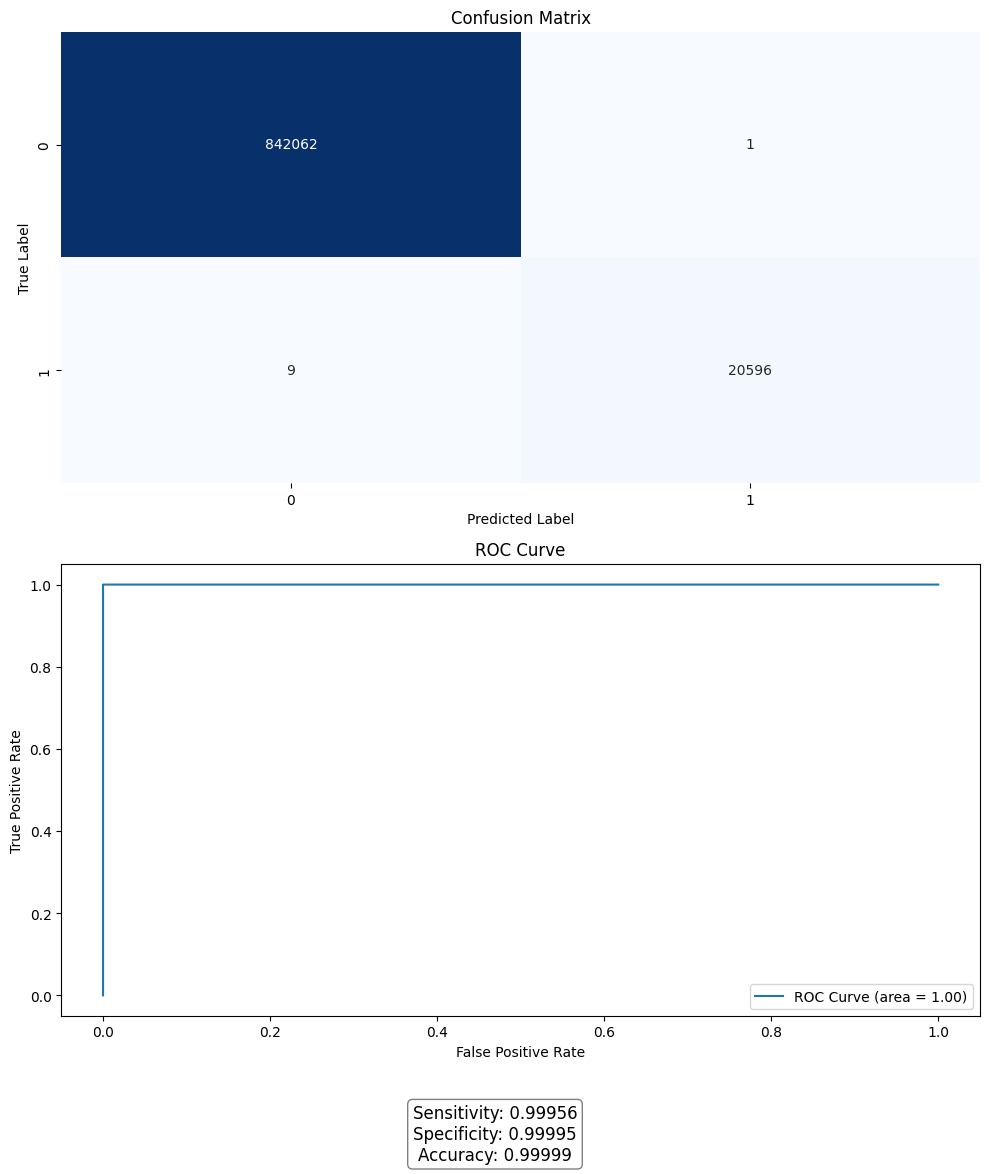

In [362]:
plot_confusion_matrix_and_roc(y_test_neo, y_pred, y_prob)

In [363]:
X_pha = df[[col for col in df.columns if col != 'pha']]
y_pha = df['pha']
nan_indices = y_pha[y_pha.isna()].index
X_pha = X_pha.drop(nan_indices)
y_pha = y_pha.drop(nan_indices)
y_pha = y_pha.replace({'N': 0, 'Y': 1})

for col in X_pha.columns:
    if X_pha[col].dtype == 'object':
        X_pha[col].fillna(X_pha[col].mode()[0], inplace=True)
    else:
        X_pha[col].fillna(X_pha[col].median(), inplace=True)

numerical_cols = X_pha.select_dtypes(include=['float64', 'int64'])

for col in numerical_cols:
    Q1 = X_pha[col].quantile(0.25)
    Q3 = X_pha[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    lower_limit = (X_pha[col] < lower_bound).mean()
    upper_limit = (X_pha[col] > upper_bound).mean()

    X_pha[col] = winsorize(X_pha[col], limits=(lower_limit, upper_limit))

del X_pha['epoch']
del X_pha['epoch_mjd']
del X_pha['epoch_cal']
numerical_cols = X_pha.select_dtypes(include=['float64', 'int64'])

X_train_pha, X_test_pha, y_train_pha, y_test_pha = train_test_split(X_pha, y_pha, test_size=0.9, stratify=X_pha['class'])

scaler = StandardScaler()
X_train_pha[numerical_cols.columns] = scaler.fit_transform(X_train_pha[numerical_cols.columns])
X_test_pha[numerical_cols.columns] = scaler.transform(X_test_pha[numerical_cols.columns])

combined = pd.concat([X_train_pha, X_test_pha])

categorical_cols = [col for col in X_pha.columns if X_pha[col].dtype == 'object']
encoder = OneHotEncoder(sparse_output=False)

combined_encoded = encoder.fit_transform(combined[categorical_cols])

X_train_encoded_pha = combined_encoded[:X_train_pha.shape[0]]
X_test_encoded_pha = combined_encoded[X_train_pha.shape[0]:]

encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
X_train_encoded_df_pha = pd.DataFrame(X_train_encoded_pha, columns=encoded_cols, index=X_train_pha.index)
X_test_encoded_df_pha = pd.DataFrame(X_test_encoded_pha, columns=encoded_cols, index=X_test_pha.index)

X_train_prepared_pha = pd.concat([X_train_pha[numerical_cols.columns], X_train_encoded_df_pha], axis=1)
X_test_prepared_pha = pd.concat([X_test_pha[numerical_cols.columns], X_test_encoded_df_pha], axis=1)


label_encoder = LabelEncoder()
y_train_pha = label_encoder.fit_transform(y_train_pha)
y_test_pha = label_encoder.transform(y_test_pha)



In [364]:
# param_grid = {
#     'n_estimators': [10, 50, 100],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

In [365]:
param_grid = {
    'n_estimators': [10, 20],
    'criterion': ['gini'],
    'max_depth': [10],
    'min_samples_split': [10],
    'min_samples_leaf': [1, 2]
}

In [366]:
rf = RandomForestClassifier()

grid_search_pha = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

In [367]:
grid_search_pha.fit(X_train_prepared_pha, y_train_pha)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [10],
                         'min_samples_leaf': [1, 2], 'min_samples_split': [10],
                         'n_estimators': [10, 20]},
             verbose=2)

In [368]:
print("Best parameters found: ", grid_search_pha.best_params_)

print("Best score found: ", grid_search_pha.best_score_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 20}
Best score found:  0.9987108459407628


In [369]:
y_pred_pha = grid_search_pha.best_estimator_.predict(X_test_prepared_pha)

print("Accuracy: ", accuracy_score(y_test_pha, y_pred_pha))

Accuracy:  0.9988446190143038


In [370]:
y_prob_pha = grid_search_pha.best_estimator_.predict_proba(X_test_prepared_pha)[:, 1]

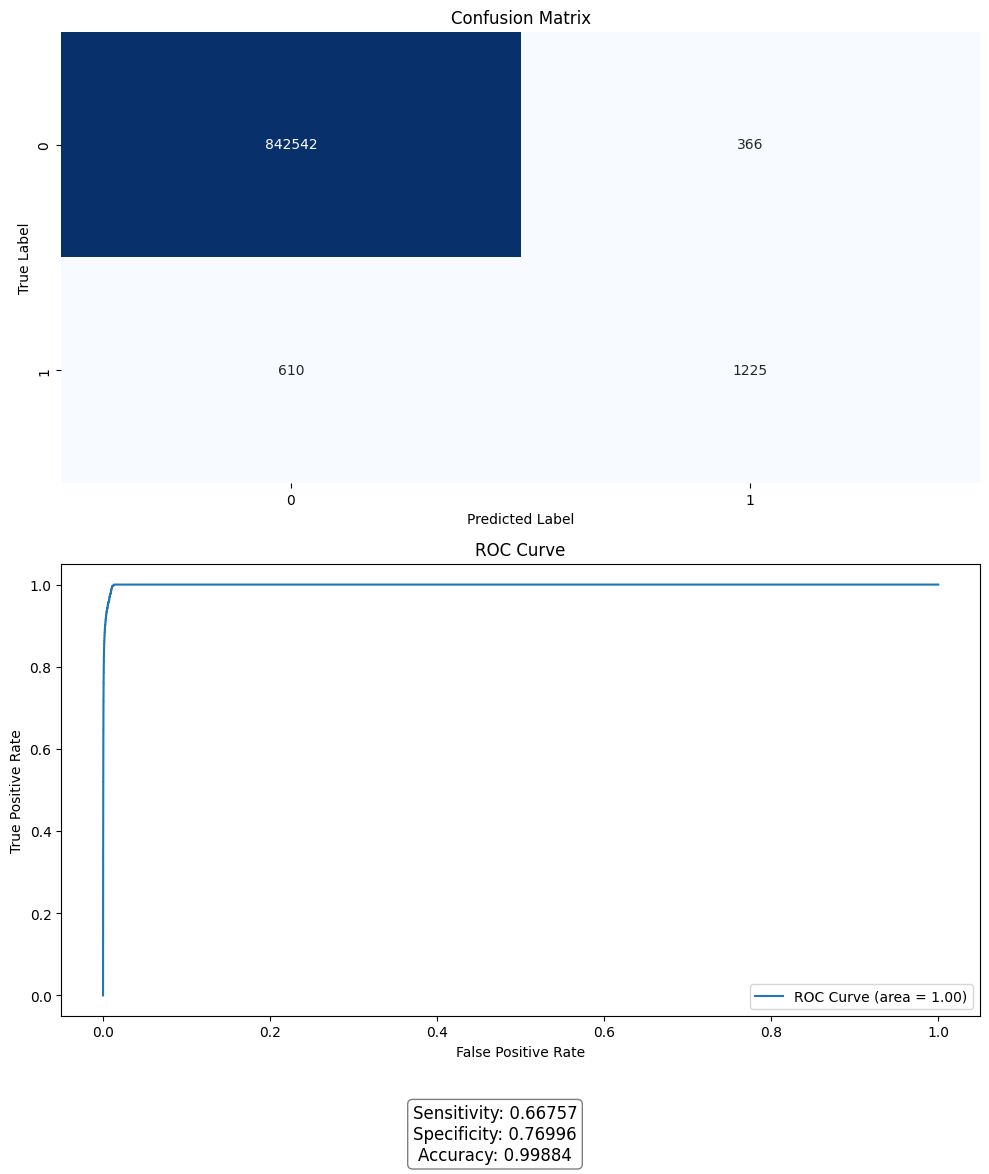

In [371]:
plot_confusion_matrix_and_roc(y_test_pha, y_pred_pha, y_prob_pha)

10  -->  0
10  -->  1
10  -->  2
10  -->  3
10  -->  4
20  -->  0
20  -->  1
20  -->  2
20  -->  3
20  -->  4
40  -->  0
40  -->  1
40  -->  2
40  -->  3
40  -->  4
70  -->  0
70  -->  1
70  -->  2
70  -->  3
70  -->  4
100  -->  0
100  -->  1
100  -->  2
100  -->  3
100  -->  4


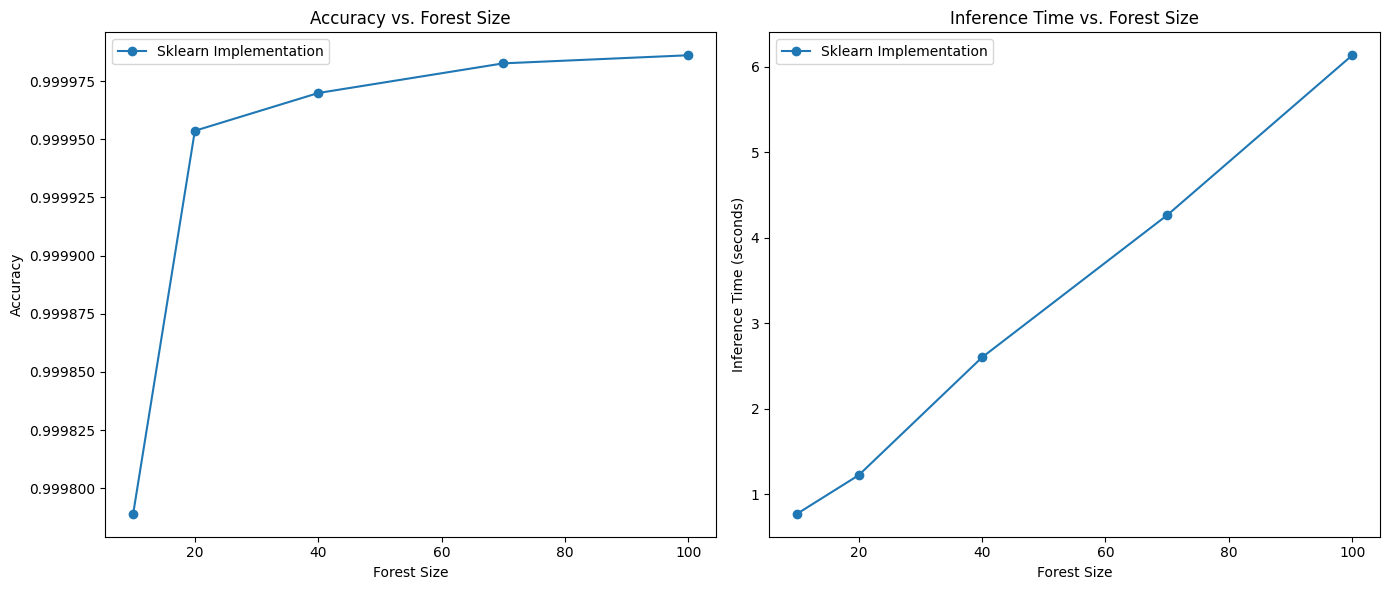

In [376]:
forest_sizes = [10, 20, 40, 70, 100]
# myimpl_accuracies = []
sklearn_accuracies = []
# myimpl_inference_times = []
sklearn_inference_times = []

for size in forest_sizes:
    # myimpl_accs = []
    # myimpl_times = []
    sklearn_accs = []
    sklearn_times = []
    
    for i in range(5):
        print(size, ' --> ', i)
        # # Measure for my implementation
        # forest = RandomForest(n_trees=size, max_features=1)
        # forest.fit(X_train_prepared_neo.values, y_train_neo.values)  # Ensure using numpy arrays
        
        # start_time = time.time()
        # y_pred = forest.predict(X_test_neo.values)  # Ensure using numpy arrays
        # end_time = time.time()
        
        # acc = accuracy(y_test_neo.values, y_pred)  # Ensure using numpy arrays
        # myimpl_accs.append(acc)
        # myimpl_times.append(end_time - start_time)
        
        # Measure for sklearn implementation
        sklearn_forest = RandomForestClassifier(n_estimators=size, max_features=1, random_state=random_state)
        sklearn_forest.fit(X_train_prepared_neo.values, y_train_neo.values)  # Ensure using numpy arrays
        
        start_time = time.time()
        sklearn_y_pred = sklearn_forest.predict(X_test_prepared_neo.values)  # Ensure using numpy arrays
        end_time = time.time()
        
        sklearn_acc = accuracy_score(y_test_neo.values, sklearn_y_pred)  # Ensure using numpy arrays
        sklearn_accs.append(sklearn_acc)
        sklearn_times.append(end_time - start_time)
    
    # myimpl_accuracies.append(np.mean(myimpl_accs))
    # myimpl_inference_times.append(np.mean(myimpl_times))
    sklearn_accuracies.append(np.mean(sklearn_accs))
    sklearn_inference_times.append(np.mean(sklearn_times))


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# plt.plot(forest_sizes, myimpl_accuracies, label='My Implementation', marker='o')
plt.plot(forest_sizes, sklearn_accuracies, label='Sklearn Implementation', marker='o')
plt.xlabel('Forest Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Forest Size')
plt.legend()

plt.subplot(1, 2, 2)
# plt.plot(forest_sizes, myimpl_inference_times, label='My Implementation', marker='o')
plt.plot(forest_sizes, sklearn_inference_times, label='Sklearn Implementation', marker='o')
plt.xlabel('Forest Size')
plt.ylabel('Inference Time (seconds)')
plt.title('Inference Time vs. Forest Size')
plt.legend()

plt.tight_layout()
plt.show()